<a href="https://colab.research.google.com/github/tnc-br/ddf-isoscapes/blob/new_kl/dnn/variational_rasters_ablated_columns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational model

Find the mean/variance of O18 ratios (as well as N15 and C13 in the future) at a particular lat/lon across Brazil. At the bottom of the colab, train and evaluate 4 different versions of the model with different data partitioning strategies.

In [47]:
from collections import defaultdict
import math
import numpy as np
import pandas as pd
import datetime
import os
from typing import List, Tuple, Dict
from dataclasses import dataclass

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from matplotlib import pyplot as plt
from tensorflow.python.ops import math_ops
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.compose import ColumnTransformer

#@title Debugging
# See https://zohaib.me/debugging-in-google-collab-notebook/ for tips,
# as well as docs for pdb and ipdb.
DEBUG = False #@param {type:"boolean"}
USE_LOCAL_DRIVE = True #@param {type:"boolean"}
LOCAL_DIR = "/usr/local/google/home/ruru/Downloads/amazon_sample_data-20230712T203059Z-001" #@param
GDRIVE_DIR = "MyDrive/amazon_rainforest_files/" #@param
FP_ROOT = LOCAL_DIR

RASTER_BASE = "/MyDrive/amazon_rainforest_files/amazon_rasters/" #@param
MODEL_SAVE_LOCATION = "/MyDrive/amazon_rainforest_files/variational/model/" #@param
OUTPUT_RASTER_BASE = "/MyDrive/amazon_rainforest_files/variational/rasters/" #@param

def get_model_save_location(filename) -> str:
  root = '' if USE_LOCAL_DRIVE else '/content/drive'
  return os.path.join(root, GDRIVE_DIR,'variational/model', filename)

def get_raster_path_from_params(filename) -> str:
  root = '' if USE_LOCAL_DRIVE else '/content/drive'
  return os.path.join(root, GDRIVE_DIR, 'amazon_rasters', filename)

def get_output_raster_path_from_params(filename) -> str:
  root = '' if USE_LOCAL_DRIVE else '/content/drive'
  return os.path.join(root, GDRIVE_DIR, 'amazon_rasters', filename)

# Access data stored on Google Drive if not reading data locally.
if not USE_LOCAL_DRIVE:
  from google.colab import drive
  drive.mount('/content/drive')
  global FP_ROOT
  FP_ROOT = os.path.join('/content/drive', GDRIVE_DIR)

if DEBUG:
    %pip install -Uqq ipdb
    import ipdb
    %pdb on

# Data preparation


In [45]:
def load_dataset(path: str):
  df = pd.read_csv(path, encoding="ISO-8859-1", sep=',')
  df = df[df['d18O_cel_variance'].notna()]

  # Family is too sparse. Too many families exist in validation/test that won't
  # exist in train, so drop it.
  X = df.drop(["d18O_cel_mean", "d18O_cel_variance", "Code", "Family", 'PET', 'Iso_Oxi_Stack_mean_TERZER',
                            'predkrig_br_lat_ISORG',
                            'isoscape_fullmodel_d18O_prec_REGRESSION', 'DEM', 'PA', "Unnamed: 0"], axis=1)
  Y = df[["d18O_cel_mean", "d18O_cel_variance"]]
  return X, Y

Standardization

In [44]:
@dataclass
class FeaturesToLabels:
  def __init__(self, X: pd.DataFrame, Y: pd.DataFrame):
    self.X = X
    self.Y = Y

  def as_tuple(self):
    return (self.X, self.Y)


def create_feature_scaler(X: pd.DataFrame) -> ColumnTransformer:
  columns_to_normalize = ['lat', 'long', 'VPD', 'RH',
       'Mean Annual Temperature', 'Mean Annual Precipitation']
  feature_scaler = ColumnTransformer([
      ('feature_normalizer', Normalizer(), columns_to_normalize)],
      remainder='passthrough')
  feature_scaler.fit(X)
  return feature_scaler

def create_label_scaler(Y: pd.DataFrame) -> ColumnTransformer:
  label_scaler = ColumnTransformer([
      ('mean_std_scaler', StandardScaler(), ['d18O_cel_mean']),
      ('var_minmax_scaler', MinMaxScaler(), ['d18O_cel_variance'])],
      remainder='passthrough')
  label_scaler.fit(Y)
  return label_scaler

def scale(X: pd.DataFrame, Y: pd.DataFrame, feature_scaler, label_scaler):
  # transform() outputs numpy arrays :(  need to convert back to DataFrame.
  X_standardized = pd.DataFrame(feature_scaler.transform(X),
                        index=X.index, columns=X.columns)
  # Y_standardized = pd.DataFrame(label_scaler.transform(Y),
  #                                     index=Y.index, columns=Y.columns)
  # FOR NOW, DO NOT SCALE Y.
  return FeaturesToLabels(X_standardized, Y)

In [ ]:
# Just a class organization, holds each scaled dataset and the scaler used.
# Useful for unscaling predictions.
@dataclass
class ScaledPartitions():
  def __init__(self,
               feature_scaler: ColumnTransformer,
               label_scaler: ColumnTransformer,
               train: FeaturesToLabels, val: FeaturesToLabels,
               test: FeaturesToLabels):
    self.feature_scaler = feature_scaler
    self.label_scaler = label_scaler
    self.train = train
    self.val = val
    self.test = test


def load_and_scale(config: Dict) -> ScaledPartitions:
  X_train, Y_train = load_dataset(config['TRAIN'])
  X_val, Y_val = load_dataset(config['VALIDATION'])
  X_test, Y_test = load_dataset(config['TEST'])

  feature_scaler = create_feature_scaler(X_train)
  label_scaler = create_label_scaler(Y_train)
  train = scale(X_train, Y_train, feature_scaler, label_scaler)
  val = scale(X_val, Y_val, feature_scaler, label_scaler)
  test = scale(X_test, Y_test, feature_scaler, label_scaler)
  return ScaledPartitions(feature_scaler, label_scaler, train, val, test)


# Model Definition



The KL Loss function:

In [34]:
# log(σ2/σ1) + ( σ1^2+(μ1−μ2)^2 ) / 2* σ^2   − 1/2
def kl_divergence(real, predicted):
    real_mean = real[:,0:1]
    real_std = tf.math.sqrt(real[:,1:2])

    predicted_mean = predicted[:,0:1]
    predicted_std = tf.math.sqrt(predicted[:,1:2])

    kl_loss = -0.5 + tf.math.log(predicted_std/real_std) + \
     (tf.square(real_std) + tf.square(real_mean - predicted_mean))/ \
     (2*tf.square(predicted_std))

    return tf.math.reduce_mean(kl_loss)

Test the loss function:

In [35]:
import pytest

test_real = tf.convert_to_tensor(np.array([[1, 0.02]]))
test_pred = tf.convert_to_tensor(np.array([[0.98, 0.021]]))

# https://screenshot.googleplex.com/5WM9dinAbhR26ZS
assert float(kl_divergence(test_real, test_pred)) == pytest.approx(0.0101094, 1e-5)

test_neg_real = tf.convert_to_tensor(np.array([[32.32, 0.0344]]))
test_neg_pred = tf.convert_to_tensor(np.array([[32.01, -0.322]]))

# Negative variance causes NaN
assert tf.math.is_nan(kl_divergence(test_neg_real, test_neg_pred))

# Calculated manually by computing the result of this equation in wolfram alpha:
# log(σ2/σ1) + ( σ1^2+(μ1−μ2)^2 ) / 2* σ^2   − 1/2
test_real_2d = tf.convert_to_tensor(np.array(
    [[1.00, 0.020],
     [1.01, 0.042]]))
test_pred_2d = tf.convert_to_tensor(np.array(
    [[0.98, 0.021],
     [0.99, 0.012]]))

# Should reduce to the average loss of all rows.
assert float(kl_divergence(test_real_2d, test_pred_2d)) == pytest.approx(
    sum([0.0101094, 0.6402851])/2, 1e-5)

Model definition

In [36]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

def get_early_stopping_callback():
  return EarlyStopping(monitor='val_loss', patience=1000, min_delta=0.001,
                       verbose=1, restore_best_weights=True, start_from_epoch=10)

tf.keras.utils.set_random_seed(18731)

# I was experimenting with models that took longer to train, and used this
# checkpointing callback to periodically save the model. It's optional.
def get_checkpoint_callback(model_file):
  return ModelCheckpoint(
      get_model_save_location(model_file),
      monitor='val_loss', verbose=0, save_best_only=True, mode='min')

def train_or_update_variational_model(
        sp: ScaledPartitions,
        hidden_layers: List[int],
        epochs: int,
        batch_size: int,
        lr: float,
        model_file=None,
        use_checkpoint=False):
  callbacks_list = [get_early_stopping_callback(),
                    get_checkpoint_callback(model_file)]
  if not use_checkpoint:
    inputs = keras.Input(shape=(sp.train.X.shape[1],))
    x = inputs
    for layer_size in hidden_layers:
      x = keras.layers.Dense(
          layer_size, activation='relu')(x)
    mean_output = keras.layers.Dense(
        1, name='mean_output')(x)

    # We can not have negative variance. Apply very little variance.
    var_output = keras.layers.Dense(
        1, name='var_output')(x)

    # Invert the normalization on our outputs
    mean_scaler = sp.label_scaler.named_transformers_['mean_std_scaler']
    untransformed_mean = mean_output * mean_scaler.var_ + mean_scaler.mean_

    var_scaler = sp.label_scaler.named_transformers_['var_minmax_scaler']
    untransformed_var = var_output * var_scaler.scale_ + var_scaler.min_

    untransformed_abs_var = keras.layers.Lambda(lambda t: tf.abs(t))(untransformed_var)

    # Output mean, |variance| tuples.
    outputs = keras.layers.concatenate([untransformed_mean, untransformed_abs_var])
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Later epochs seem to benefit from lower learning rate... but it takes
    # a while to get there.
    decay = keras.optimizers.schedules.ExponentialDecay(
       lr, decay_steps=100, decay_rate=0.5, staircase=True)

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=kl_divergence)
    model.summary()
  else:
    model = keras.models.load_model(
        get_model_save_location(model_file),
        custom_objects={"kl_divergence": kl_divergence})
  history = model.fit(sp.train.X, sp.train.Y, verbose=0, epochs=epochs, batch_size=batch_size,
                      validation_data=sp.val.as_tuple(),
                      shuffle=True, callbacks=callbacks_list)
  return history, model

In [37]:
from sklearn.metrics import mean_squared_error

def render_plot_loss(history, name):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(name + ' model loss')
  plt.ylabel('loss')
  plt.yscale("log")
  plt.ylim((0, 10))
  plt.xlabel('epoch')
  plt.legend(['loss', 'val_loss'], loc='upper left')
  plt.show()

def destandardize(sd: ScaledPartitions, df: pd.DataFrame):
  means = pd.DataFrame(
      sd.label_scaler.named_transformers_['var_std_scaler'].inverse_transform(df[['d18O_cel_mean']]),
      index=df.index, columns=['d18O_cel_mean'])
  vars = df['d18O_cel_variance']
  return means.join(vars)

def train_and_evaluate(sp: ScaledPartitions, run_id: str, training_batch_size=5):
  print("==================")
  print(run_id)
  history, model = train_or_update_variational_model(
      sp, hidden_layers=[20, 20], epochs=5000, batch_size=training_batch_size,
      lr=0.0001, model_file=run_id+".h5", use_checkpoint=False)
  render_plot_loss(history, run_id+" kl_loss")
  model.save(get_model_save_location(run_id+".h5"), save_format="h5")

  model.evaluate(x=sp.test.X, y=sp.test.Y)
  predictions = model.predict_on_batch(sp.test.X)
  print("EXPECTED:")
  print(sp.test.Y.to_string())
  print()
  print("PREDICTED:")
  predictions = pd.DataFrame(predictions, columns=['d18O_cel_mean', 'd18O_cel_variance'])
  print(predictions.to_string())

  rmse = np.sqrt(mean_squared_error(sp.test.Y['d18O_cel_mean'], predictions['d18O_cel_mean']))
  print("RMSE: "+ str(rmse))
  return model

# Load and evaluate the model with each set of data.

Use the same model configured the same way for every run, with the exception of the training batch size setting, which is 1 for grouped and 5 for ungrouped.

In [2]:
from dataclasses import dataclass
from osgeo import gdal, gdal_array
from tqdm import tqdm
import math
import matplotlib.animation as animation

@dataclass
class AmazonGeoTiff:
  """Represents a geotiff from our dataset."""
  gdal_dataset: gdal.Dataset
  image_value_array: np.ndarray # ndarray of floats
  image_mask_array: np.ndarray # ndarray of uint8
  masked_image: np.ma.masked_array
  yearly_masked_image: np.ma.masked_array


@dataclass
class Bounds:
  """Represents geographic bounds and size information."""
  minx: float
  maxx: float
  miny: float
  maxy: float
  pixel_size_x: float
  pixel_size_y: float
  raster_size_x: float
  raster_size_y: float

  def to_matplotlib(self) -> List[float]:
      return [self.minx, self.maxx, self.miny, self.maxy]

def load_raster(path: str, use_only_band_index: int = -1) -> AmazonGeoTiff:
  """
  TODO: Refactor (is_single_band, etc., should be a better design)
  --> Find a way to simplify this logic. Maybe it needs to be more abstract.
  """
  dataset = gdal.Open(path, gdal.GA_ReadOnly)
  image_datatype = dataset.GetRasterBand(1).DataType
  mask_datatype = dataset.GetRasterBand(1).GetMaskBand().DataType
  image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, 12),
                   dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))
  mask = np.zeros((dataset.RasterYSize, dataset.RasterXSize, 12),
                  dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))

  if use_only_band_index == -1:
    if dataset.RasterCount != 12 and dataset.RasterCount != 1:
      raise ValueError(f"Expected 12 raster bands (one for each month) or one annual average, but found {dataset.RasterCount}")
    if dataset.RasterCount == 1:
      use_only_band_index = 0

  is_single_band = use_only_band_index != -1

  if is_single_band and use_only_band_index >= dataset.RasterCount:
    raise IndexError(f"Specified raster band index {use_only_band_index}"
                     f" but there are only {dataset.RasterCount} rasters")

  for band_index in range(12):
    band = dataset.GetRasterBand(use_only_band_index+1 if is_single_band else band_index+1)
    image[:, :, band_index] = band.ReadAsArray()
    mask[:, :, band_index] = band.GetMaskBand().ReadAsArray()
  masked_image = np.ma.masked_where(mask == 0, image)
  yearly_masked_image = masked_image.mean(axis=2)

  return AmazonGeoTiff(dataset, image, mask, masked_image, yearly_masked_image)

def get_extent(dataset):
  geoTransform = dataset.GetGeoTransform()
  minx = geoTransform[0]
  maxy = geoTransform[3]
  maxx = minx + geoTransform[1] * dataset.RasterXSize
  miny = maxy + geoTransform[5] * dataset.RasterYSize
  return Bounds(minx, maxx, miny, maxy, geoTransform[1], geoTransform[5], dataset.RasterXSize, dataset.RasterYSize)

def coords_to_indices(bounds: Bounds, x: float, y: float):
  if x < bounds.minx or x > bounds.maxx or y < bounds.miny or y > bounds.maxy:
    raise ValueError("Coordinates out of bounds")

  # X => lat, Y => lon
  x_idx = bounds.raster_size_y - int(math.ceil((y - bounds.miny) / abs(bounds.pixel_size_y)))
  y_idx = int((x - bounds.minx) / abs(bounds.pixel_size_x))

  return x_idx, y_idx

def get_data_at_coords(dataset: AmazonGeoTiff, x: float, y: float, month: int) -> float:
  # x = longitude
  # y = latitude
  bounds = get_extent(dataset.gdal_dataset)
  x_idx, y_idx = coords_to_indices(bounds, x, y)
  if month == -1:
    value = dataset.yearly_masked_image[x_idx, y_idx]
  else:
    value = dataset.masked_image[x_idx, y_idx, month]
  if np.ma.is_masked(value):
    raise ValueError("Coordinates are masked")
  else:
    return value

def animate(geotiff: AmazonGeoTiff, nSeconds, fps):
  fig = plt.figure( figsize=(8,8) )

  months = []
  labels = []
  for m in range(12):
    months.append(geotiff.masked_image[:,:,m])
    labels.append(f"Month: {m+1}")
  a = months[0]
  extent = get_extent(geotiff.gdal_dataset).to_matplotlib()
  ax = fig.add_subplot()
  im = fig.axes[0].imshow(a, interpolation='none', aspect='auto', extent = extent)
  txt = fig.text(0.3,0,"", fontsize=24)
  fig.colorbar(im)

  def animate_func(i):
    if i % fps == 0:
      print( '.', end ='' )

    im.set_array(months[i])
    txt.set_text(labels[i])
    return [im, txt]

  anim = animation.FuncAnimation(
      fig,
      animate_func,
      frames = nSeconds * fps,
      interval = 1000 / fps, # in ms
  )
  plt.close()

  return anim


def get_predictions_at_each_pixel(
    monthly: bool,
    geotiffs: dict[str, AmazonGeoTiff],
    bounds: Bounds,
    model: keras.Model):

  # Initialize a blank plane representing means and variance.
  predicted_means_np = np.ma.array(
      np.zeros([bounds.raster_size_x, bounds.raster_size_y, 12 if monthly else 1], dtype=float),
      mask=np.ones([bounds.raster_size_x, bounds.raster_size_y, 12 if monthly else 1], dtype=bool))
  predicted_vars_np = np.ma.array(
      np.zeros([bounds.raster_size_x, bounds.raster_size_y, 12 if monthly else 1], dtype=float),
      mask=np.ones([bounds.raster_size_x, bounds.raster_size_y, 12 if monthly else 1], dtype=bool))

  for month in range (0, 12 if monthly else 1):
    for x_idx, x in enumerate(tqdm(np.arange(bounds.minx, bounds.maxx, bounds.pixel_size_x, dtype=float))):
      rows = []
      row_indexes = []
      for y_idx, y in enumerate(np.arange(bounds.miny, bounds.maxy, -bounds.pixel_size_y, dtype=float)):
        # Row should contain all the features needed to predict.
        row = {}
        row["lat"] = y
        row["long"] = x

        # Surround in try/except as we will be trying to fetch out of bounds data.
        try:
          for geotiff_label, geotiff in geotiffs.items():
            row[geotiff_label] = get_data_at_coords(geotiff, x, y, month if monthly else -1)
        except (ValueError, IndexError):
          continue # masked and out-of-bounds coordinates

        # Set all month_of_year binary variables to 0 unless it refers to `month`.
        if monthly:
          for i in range(0,12):
            row["month_of_year_" + str(i)] = (1 if i == month else 0)
        rows.append(row)
        row_indexes.append((y_idx,month,))

      if (len(rows) > 0):
        X = pd.DataFrame.from_dict(rows)
        X = normalize(X, normalization_factors)
        predictions = model.predict_on_batch(X)

        means_np = predictions[:, 0]
        for prediction, (y_idx, month_idx) in zip(means_np, row_indexes):
          predicted_means_np.mask[x_idx,y_idx,month_idx] = False # unmask since we have data
          predicted_means_np.data[x_idx,y_idx,month_idx] = prediction
        vars_np = predictions[:, 1]
        for prediction, (y_idx, month_idx) in zip (vars_np, row_indexes):
          predicted_vars_np.mask[x_idx, y_idx, month_idx] = False
          predicted_vars_np.data[x_idx, y_idx, month_idx] = prediction

  return predicted_means_np, predicted_vars_np

from osgeo import gdal, gdal_array

def save_numpy_to_geotiff(bounds: Bounds, prediction: np.ma.MaskedArray, path: str):
  """Copy metadata from a base geotiff and write raster data + mask from `data`"""
  driver = gdal.GetDriverByName("GTiff")
  metadata = driver.GetMetadata()
  if metadata.get(gdal.DCAP_CREATE) != "YES":
    raise RuntimeError("GTiff driver does not support required method Create().")
  if metadata.get(gdal.DCAP_CREATECOPY) != "YES":
    raise RuntimeError("GTiff driver does not support required method CreateCopy().")

  dataset = driver.Create(path, bounds.raster_size_x, bounds.raster_size_y, prediction.shape[2], eType=gdal.GDT_Float64)
  dataset.SetGeoTransform([bounds.minx, bounds.pixel_size_x, 0, bounds.maxy, 0, bounds.pixel_size_y])
  dataset.SetProjection('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]')

  if len(prediction.shape) != 3 or prediction.shape[0] != bounds.raster_size_x or prediction.shape[1] != bounds.raster_size_y:
    raise ValueError("Shape of prediction does not match base geotiff")

  prediction_transformed = np.flip(np.transpose(prediction, axes=[1,0,2]), axis=0)
  for band_index in range(dataset.RasterCount):
    band = dataset.GetRasterBand(band_index+1)
    if band.CreateMaskBand(0) == gdal.CE_Failure:
      raise RuntimeError("Failed to create mask band")
    mask_band = band.GetMaskBand()
    band.WriteArray(np.choose(prediction_transformed[:, :, band_index].mask, (prediction_transformed[:, :, band_index].data,np.array(band.GetNoDataValue()),)))
    mask_band.WriteArray(np.logical_not(prediction_transformed[:, :, band_index].mask))

relative_humidity_geotiff = load_raster(get_raster_path_from_params("R.rh_Stack.tif"))
temperature_geotiff = load_raster(get_raster_path_from_params("Temperatura_Stack.tif"))
vapor_pressure_deficit_geotiff = load_raster(get_raster_path_from_params("R.vpd_Stack.tif"))
atmosphere_isoscape_geotiff = load_raster(get_raster_path_from_params("Iso_Oxi_Stack.tif"))
precipitation_geotiff = load_raster(get_raster_path_from_params("brasil_clim_raster.tiff"))

name_to_geotiff = {
    "VPD" : vapor_pressure_deficit_geotiff,
    "RH": relative_humidity_geotiff,
    "Mean Annual Temperature" : temperature_geotiff,
    "Mean Annual Precipitation" : precipitation_geotiff,
}

# We need the borders of the map. Pick one geotiff at random and use that as the extent.
bounds =  get_extent(atmosphere_isoscape_geotiff.gdal_dataset)

means_np, vars_np = get_predictions_at_each_pixel(
    monthly=False,
    geotiffs=name_to_geotiff,
    bounds=bounds,
    model=model)

def create_rasters(model, run_id):
  means_np, vars_np = get_predictions_at_each_pixel(
    monthly=False,
    geotiffs=name_to_geotiff,
    bounds=bounds,
    model=model)
  save_numpy_to_geotiff(bounds, means_np, get_output_raster_path_from_params(run_id+"means.tiff"))
  save_numpy_to_geotiff(bounds, vars_np, get_output_raster_path_from_params(run_id+"vars.tiff"))

ModuleNotFoundError: ignored

### 1) Ungrouped, random

ungrouped_random
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 9)]          0           []                               
                                                                                                  
 dense_26 (Dense)               (None, 20)           200         ['input_14[0][0]']               
                                                                                                  
 dense_27 (Dense)               (None, 20)           420         ['dense_26[0][0]']               
                                                                                                  
 var_output (Dense)             (None, 1)            21          ['dense_27[0][0]']               
                                                                          

/tmp/ipykernel_1157772/719499732.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 10))


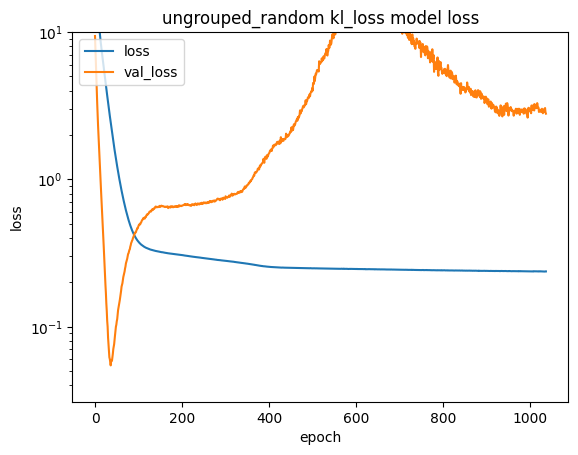

2/2 [==============================] - 0s 2ms/step - loss: 1.7474
EXPECTED:
    d18O_cel_mean  d18O_cel_variance
0       26.663818           0.574594
1       26.663818           0.574594
2       26.663818           0.574594
3       27.559140           0.780698
4       27.559140           0.780698
5       27.559140           0.780698
6       27.559140           0.780698
7       27.559140           0.780698
8       27.559140           0.780698
9       27.559140           0.780698
10      27.559140           0.780698
11      27.559140           0.780698
12      27.559140           0.780698
13      27.260748           0.830341
14      27.260748           0.830341
15      27.260748           0.830341
16      27.260748           0.830341
17      27.260748           0.830341
18      27.260748           0.830341
19      27.260748           0.830341
20      27.260748           0.830341
21      27.260748           0.830341
22      27.260748           0.830341
23      27.260748           0.830341

2023-07-27 16:09:37.077994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [63,9]
	 [[{{node Placeholder/_0}}]]


In [41]:
ungrouped_random = {
    'TRAIN' : os.path.join(FP_ROOT, "amazon_sample_data/uc_davis_2023_08_12_train_random_ungrouped.csv"),
    'TEST' : os.path.join(FP_ROOT, "amazon_sample_data/uc_davis_2023_08_12_test_random_ungrouped.csv"),
    'VALIDATION' : os.path.join(FP_ROOT, "amazon_sample_data/uc_davis_2023_08_12_validation_random_ungrouped.csv"),
}

ungrouped_random_scaled = load_and_scale(ungrouped_random)
model = train_and_evaluate(ungrouped_random_scaled, "ungrouped_random", training_batch_size=3)

### 2) Ungrouped, fixed

ungrouped_fixed
Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 9)]          0           []                               
                                                                                                  
 dense_28 (Dense)               (None, 20)           200         ['input_15[0][0]']               
                                                                                                  
 dense_29 (Dense)               (None, 20)           420         ['dense_28[0][0]']               
                                                                                                  
 var_output (Dense)             (None, 1)            21          ['dense_29[0][0]']               
                                                                           

/tmp/ipykernel_1157772/719499732.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 10))


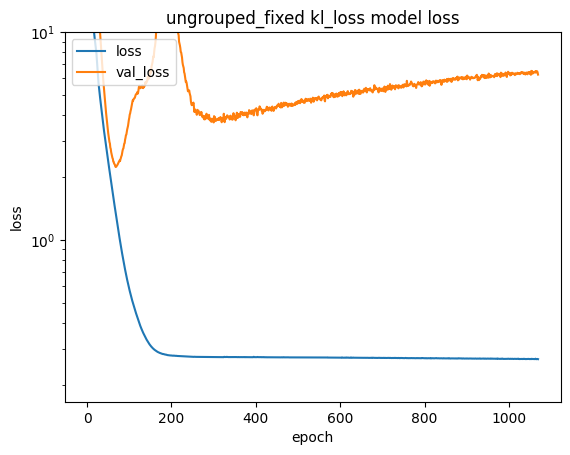

4/4 [==============================] - 0s 1ms/step - loss: 2.7880
EXPECTED:
     d18O_cel_mean  d18O_cel_variance
0        25.120750           0.844007
1        25.120750           0.844007
2        25.120750           0.844007
3        25.120750           0.844007
4        25.120750           0.844007
5        25.120750           0.844007
6        25.120750           0.844007
7        25.120750           0.844007
8        25.120750           0.844007
9        25.120750           0.844007
10       25.120750           0.844007
11       25.120750           0.844007
12       25.120750           0.844007
13       25.120750           0.844007
14       25.120750           0.844007
15       25.120750           0.844007
16       25.120750           0.844007
17       25.120750           0.844007
18       25.120750           0.844007
19       25.120750           0.844007
20       25.120750           0.844007
21       25.120750           0.844007
22       25.120750           0.844007
23       25.

2023-07-27 16:12:27.259702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [109,9]
	 [[{{node Placeholder/_0}}]]


In [42]:
ungrouped_fixed = {
    'TRAIN' : os.path.join(FP_ROOT, "amazon_sample_data/uc_davis_2023_08_12_train_fixed_ungrouped.csv"),
    'TEST' : os.path.join(FP_ROOT, "amazon_sample_data/uc_davis_2023_08_12_test_fixed_ungrouped.csv"),
    'VALIDATION' : os.path.join(FP_ROOT, "amazon_sample_data/uc_davis_2023_08_12_validation_fixed_ungrouped.csv"),
}

ungrouped_fixed_scaled = load_and_scale(ungrouped_fixed)
train_and_evaluate(ungrouped_fixed_scaled, "ungrouped_fixed", training_batch_size=3)

### 3) Grouped, random

grouped_random
Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 6)]          0           []                               
                                                                                                  
 dense_30 (Dense)               (None, 20)           140         ['input_16[0][0]']               
                                                                                                  
 dense_31 (Dense)               (None, 20)           420         ['dense_30[0][0]']               
                                                                                                  
 var_output (Dense)             (None, 1)            21          ['dense_31[0][0]']               
                                                                            

/tmp/ipykernel_1157772/719499732.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 10))


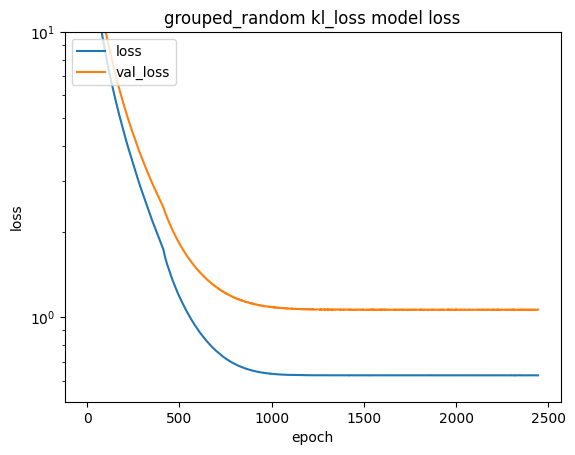

1/1 [==============================] - 0s 23ms/step - loss: 0.6380
EXPECTED:
   d18O_cel_mean  d18O_cel_variance
0      25.882000           0.233670
1      25.654000           0.334480
2      27.207456           1.041823
3      25.163333           0.807832
4      24.030630           0.579233
5      26.040923           0.222859

PREDICTED:
   d18O_cel_mean  d18O_cel_variance
0      25.335857           2.077736
1      25.335869           2.077563
2      25.335722           2.078409
3      25.336050           2.073184
4      25.336050           2.073184
5      25.336002           2.073817
RMSE: 1.0110828632773607


2023-07-27 16:25:44.576663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [6,6]
	 [[{{node Placeholder/_0}}]]


In [46]:
grouped_random = {
    'TRAIN' : os.path.join(FP_ROOT, 'amazon_sample_data/uc_davis_2023_08_12_train_random_grouped.csv'),
    'TEST' : os.path.join(FP_ROOT, 'amazon_sample_data/uc_davis_2023_08_12_test_random_grouped.csv'),
    'VALIDATION' : os.path.join(FP_ROOT, 'amazon_sample_data/uc_davis_2023_08_12_validation_random_grouped.csv'),
}

grouped_random_scaled = load_and_scale(grouped_random)
model = train_and_evaluate(grouped_random_scaled, "grouped_random", training_batch_size=3)


### 4) Grouped, fixed

grouped_fixed
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 9)]          0           []                               
                                                                                                  
 dense_22 (Dense)               (None, 20)           200         ['input_12[0][0]']               
                                                                                                  
 dense_23 (Dense)               (None, 20)           420         ['dense_22[0][0]']               
                                                                                                  
 var_output (Dense)             (None, 1)            21          ['dense_23[0][0]']               
                                                                             

/tmp/ipykernel_1157772/719499732.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 10))


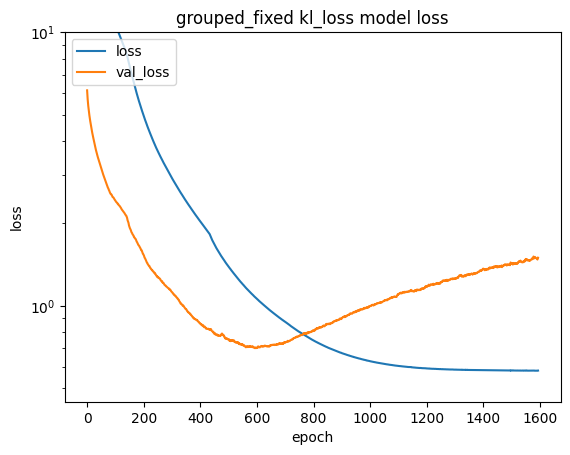

1/1 [==============================] - 0s 19ms/step - loss: 1.1644
EXPECTED:
   d18O_cel_mean  d18O_cel_variance
0      27.559140           0.780698
1      27.260748           0.830341
2      24.777670           0.736571
3      25.987815           5.280825
4      25.551850           0.312355
5      25.115885           0.033519
6      24.132031           0.389042
7      25.120750           0.844007

PREDICTED:
   d18O_cel_mean  d18O_cel_variance
0      24.450321           2.111468
1      24.450323           2.111468
2      25.482237           3.521082
3      24.516850           5.269522
4      24.636921           5.153113
5      24.641626           5.146006
6      24.636919           5.153111
7      25.638115           2.259322
RMSE: 1.6510598923275581


2023-07-27 16:02:13.986018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [8,9]
	 [[{{node Placeholder/_0}}]]


In [39]:
grouped_fixed = {
    'TRAIN': os.path.join(FP_ROOT, "amazon_sample_data/uc_davis_2023_08_12_train_fixed_grouped.csv"),
    'TEST': os.path.join(FP_ROOT, "amazon_sample_data/uc_davis_2023_08_12_test_fixed_grouped.csv"),
    'VALIDATION': os.path.join(FP_ROOT, "amazon_sample_data/uc_davis_2023_08_12_validation_fixed_grouped.csv"),
}

grouped_fixed_scaled = load_and_scale(grouped_fixed)
train_and_evaluate(grouped_fixed_scaled, "grouped_fixed", training_batch_size=3)